
Загрузка данных...
  Начальное состояние КА относительно Марса:
    Положение: (32343.8, 14006.1, -24913.2) км
    |r| = 43162.0 км
    |v| = 0.7607 км/с

  Опорная частота (ref_freq):
    Значение: 70205.932 МГц = 70.205932 ГГц

Интегрирование орбиты...
  Начало: 1997-09-19T04:05:30
  Длительность: 2 суток, шаг: 10 сек
  Радиус орбиты: 3514.9 - 57414.9 км

Вычисление доплера...


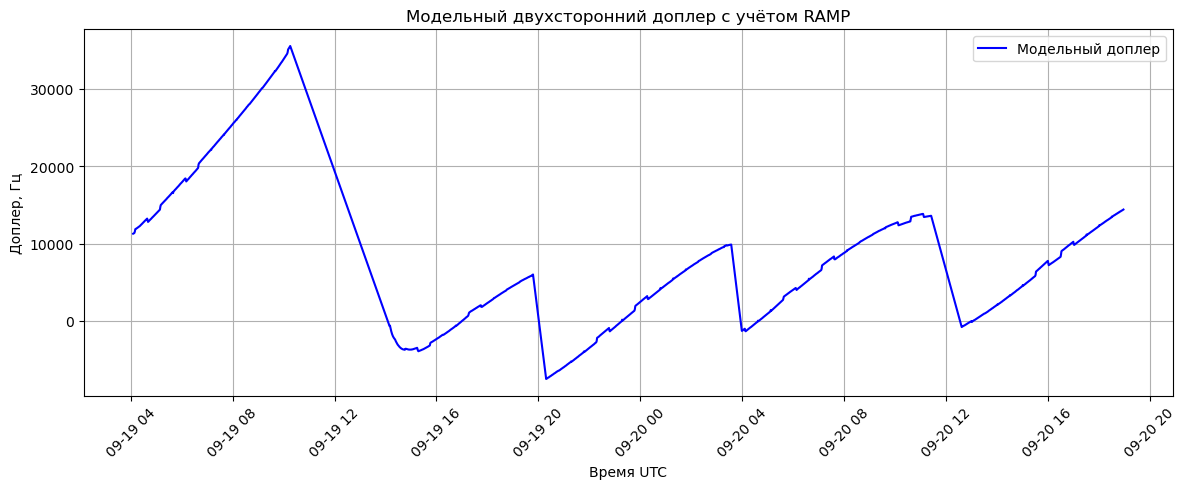

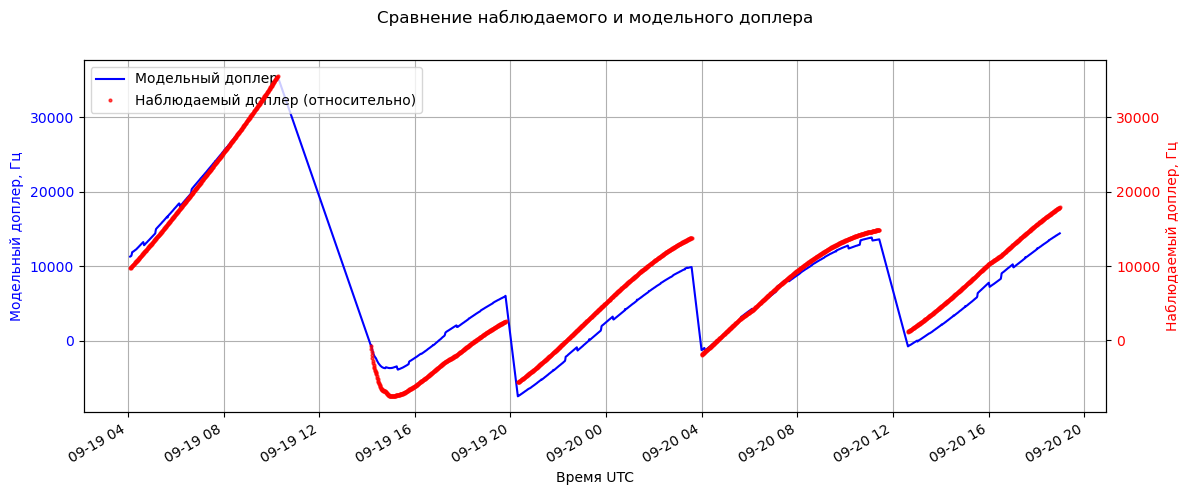

            datetime_utc    doppler_hz  doppler_model_hz  v_radial_m_s
0    1997-09-19 04:05:30   9734.105515      11274.643559      0.048145
1    1997-09-19 04:06:30   9794.050559      11299.006587      0.048249
2    1997-09-19 04:07:30   9854.052135      11345.970980      0.048449
3    1997-09-19 04:08:30   9914.109458      11381.634693      0.048602
4    1997-09-19 04:09:30   9972.223184      11567.166985      0.049394
...                  ...           ...               ...           ...
1967 1997-09-20 18:54:30  17738.213296      14254.132971      0.060868
1968 1997-09-20 18:55:30  17775.133664      14286.581081      0.061006
1969 1997-09-20 18:56:30  17812.001676      14319.029191      0.061145
1970 1997-09-20 18:57:30  17848.047944      14362.777991      0.061332
1971 1997-09-20 18:58:30  17884.043885      14395.226102      0.061470

[1972 rows x 4 columns]


In [4]:
"""
Прямая задача: работа с вариациями доплера с учётом RAMP. 
"""

import numpy as np
import pandas as pd
import spiceypy as spice
from scipy.interpolate import interp1d
from scipy.signal import detrend
import os
import matplotlib.pyplot as plt
from datetime import datetime

# Константы
KERNEL_DIR = './spice_data/'
GEOMETRY_FILE = './output_data/mgs_geometry.csv'
DOPPLER_FILE = './output_data/mgs_doppler_CLEANED.csv'
RAMP_FILE = './output_data/mgs_ramp_CLEANED.csv'
OUTPUT_DIR = './output_data/'

GM = {
    'sun':       132712440041.93938,
    'mercury':   22031.868551,
    'venus':     324858.592,
    'earth':     398600.435507,
    'moon':      4902.800118,
    'mars':      42828.375816,
    'jupiter':   126712764.100,
    'saturn':    37940584.841,
    'uranus':    5794556.400,
    'neptune':   6836527.100,
}

C_LIGHT = 299792.458  # km/s
MARS_RE = 3396.19     # km
M2 = 880.0 / 749.0    # коэффициент двухстороннего доплера

SCALE_R = 1e5         # более жёсткое масштабирование параметров r (км) #TODO: настроить
BIAS_INIT = 0.0       # начальный доплер-сдвиг (Гц), оценим вместе с r0

BODIES = [
    (10, GM["sun"]), (1, GM["mercury"]), (2, GM["venus"]),
    (3, GM["earth"]), (301, GM["moon"]), (4, GM["mars"]),
    (5, GM["jupiter"]), (6, GM["saturn"]), (7, GM["uranus"]),
    (8, GM["neptune"])
]

DSN_STATIONS = {
    15: {'lon': -116.887, 'lat': 35.422, 'height': 973.21},
    45: {'lon': 148.978, 'lat': -35.402, 'height': 674.35},
    65: {'lon': -4.255, 'lat': 40.427, 'height': 833.85},
}

# SPICE
def load_kernels():
    """Загружает SPICE kernels."""
    kernels = [
        'naif0010.tls',        # Leap seconds (обязательно!)
        'pck00010.tpc',        # Базовый PCK - ДОБАВЬТЕ ЭТОТ
        'earth_720101_070426.bpc',
        'de442s.bsp',          # Планетарные эфемериды
        'mgs_ab1.bsp',         # MGS орбита
        'dsnstns.bsp',         # DSN станции
    ]
    for k in kernels:
        path = os.path.join(KERNEL_DIR, k)
        if os.path.exists(path):
            try:
                spice.furnsh(path)
            except Exception:
                pass

def get_body_state(body_id, t_et):
    """Состояние тела в SSB J2000."""
    state, _ = spice.spkezr(str(body_id), t_et, 'J2000', 'NONE', '0')
    return np.array(state[:3]), np.array(state[3:6])

def get_mars_state(t_et):
    return get_body_state(4, t_et)

def get_earth_state(t_et):
    return get_body_state(3, t_et)

def get_dsn_station_state(station_id, t_et):
    station_name = f"DSS-{station_id}"
    try:
        state_earth, _ = spice.spkezr(station_name, t_et, "J2000", "NONE", "EARTH")
        r_st_earth = np.array(state_earth[:3])
        v_st_earth = np.array(state_earth[3:6])
        r_earth, v_earth = get_earth_state(t_et)
        return r_earth + r_st_earth, v_earth + v_st_earth
    except Exception:
        return np.zeros(3), np.zeros(3)


# Динамика космического аппарата
def compute_acceleration(t_et, r_sc_mars):
    """Ускорение КА относительно Марса."""
    r_mars, v_mars = get_mars_state(t_et)
    r_sc = r_mars + r_sc_mars
    
    a_sc = np.zeros(3)
    a_mars = np.zeros(3)
    
    for naif_id, gm in BODIES:
        try:
            r_body, _ = get_body_state(naif_id, t_et)
        except:
            continue
        
        # Ускорение КА от тела
        r_to = r_body - r_sc
        d = np.linalg.norm(r_to)
        if d > 1e-10:
            a_sc += gm * r_to / d**3
        
        # Ускорение Марса от тела (кроме самого Марса)
        if naif_id != 4:
            r_to_mars = r_body - r_mars
            d_mars = np.linalg.norm(r_to_mars)
            if d_mars > 1e-10:
                a_mars += gm * r_to_mars / d_mars**3
    
    return a_sc - a_mars

def compute_acceleration_jacobian(t_et, r_sc_mars):
    r_mars, _ = get_mars_state(t_et)
    r_sc_ssb = r_mars + r_sc_mars
    J = np.zeros((3, 3))
    I = np.eye(3)
    for naif_id, gm in BODIES:
        try:
            r_body, _ = get_body_state(naif_id, t_et)
        except Exception:
            continue
        r_sc = r_body - r_sc_ssb
        d = np.linalg.norm(r_sc)
        if d > 1e-10:
            outer = np.outer(r_sc, r_sc)
            J += -gm * (I / d**3 - 3.0 * outer / d**5)
    return J

def rk5_step_variational(t_rel, y, dt, t_et_start):
    """
    y = [r(3), v(3), Φ_rr(9), Φ_vr(9)] -> 24 компонентов.
    """
    c = [0, 0.2, 0.3, 0.8, 8/9, 1, 1]
    a_rk = [[],
            [0.2],
            [3/40, 9/40],
            [44/45, -56/15, 32/9],
            [19372/6561, -25360/2187, 64448/6561, -212/729],
            [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656],
            [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84]]
    b = [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0]

    def f(t, yv):
        t_et = t_et_start + t
        r = yv[0:3]
        v = yv[3:6]
        Phi_rr = yv[6:15].reshape(3, 3)
        Phi_vr = yv[15:24].reshape(3, 3)

        a = compute_acceleration(t_et, r)
        J = compute_acceleration_jacobian(t_et, r)

        dr_dt = v
        dv_dt = a
        dPhi_rr_dt = Phi_vr
        dPhi_vr_dt = J @ Phi_rr

        return np.concatenate([dr_dt, dv_dt,
                               dPhi_rr_dt.flatten(), dPhi_vr_dt.flatten()])

    k = [None] * 7
    k[0] = f(t_rel, y)
    for i in range(1, 7):
        y_temp = y + dt * sum(a_rk[i][j] * k[j] for j in range(i))
        k[i] = f(t_rel + c[i] * dt, y_temp)
    return y + dt * sum(b[i] * k[i] for i in range(7))

def integrate_with_variational(t0_et, state0, t_end_et, dt=10.0):
    y = np.zeros(24)
    y[0:6] = state0
    y[6:15] = np.eye(3).flatten()
    y[15:24] = np.zeros(9)

    times = [t0_et]
    states = [state0.copy()]
    Phi_rr_list = [np.eye(3)]

    t_rel = 0.0
    duration = t_end_et - t0_et
    while t_rel < duration:
        dt_step = min(dt, duration - t_rel)
        y = rk5_step_variational(t_rel, y, dt_step, t0_et)
        t_rel += dt_step
        times.append(t0_et + t_rel)
        states.append(y[0:6].copy())
        Phi_rr_list.append(y[6:15].reshape(3, 3).copy())

    return {"times": np.array(times),
            "states": np.array(states),
            "Phi_rr": Phi_rr_list}

def create_interpolators(orbit_data):
    times = orbit_data["times"]
    states = orbit_data["states"]
    Phi_rr_list = orbit_data["Phi_rr"]

    interp_r = interp1d(times, states[:, :3], axis=0, kind="linear",
                        fill_value="extrapolate", bounds_error=False)
    interp_v = interp1d(times, states[:, 3:6], axis=0, kind="linear",
                        fill_value="extrapolate", bounds_error=False)
    Phi_rr_arr = np.array([phi.flatten() for phi in Phi_rr_list])
    interp_Phi_rr = interp1d(times, Phi_rr_arr, axis=0, kind="linear",
                             fill_value="extrapolate", bounds_error=False)

    def get_sc_state_ssb(t):
        r_mars, v_mars = get_mars_state(t)
        return r_mars + interp_r(t), v_mars + interp_v(t)

    def get_Phi_rr(t):
        return interp_Phi_rr(t).reshape(3, 3)

    return get_sc_state_ssb, get_Phi_rr

def save_orbit_to_csv(t0_et, orbit_data, filename):
    r_mars, _ = get_mars_state(t0_et)
    r_sun, _  = get_body_state(10, t0_et)
    mars_sun = r_sun - r_mars

    rows = []
    for t, state in zip(orbit_data['times'], orbit_data['states']):
        rows.append({
            'datetime_utc': spice.et2utc(t, 'ISOC', 3),
            'mgs_x_km': state[0],
            'mgs_y_km': state[1],
            'mgs_z_km': state[2],
            'mgs_vx_km_s': state[3],
            'mgs_vy_km_s': state[4],
            'mgs_vz_km_s': state[5],
        })

    df = pd.DataFrame(rows)

    df['mars_sun_x_km'] = mars_sun[0]
    df['mars_sun_y_km'] = mars_sun[1]
    df['mars_sun_z_km'] = mars_sun[2]

    df.to_csv(filename, index=False)


# Доплер
def solve_light_time(t_recv, get_sc_state_ssb, station_id, max_iter=20, tol=1e-12):
    t3 = t_recv
    t2 = t3
    t1 = t3
    for _ in range(max_iter):
        r3_ssb, _ = get_dsn_station_state(station_id, t3)
        r2_ssb, _ = get_sc_state_ssb(t2)
        rho_dn = np.linalg.norm(r3_ssb - r2_ssb)
        t2_new = t3 - rho_dn / C_LIGHT

        r2_ssb_new, _ = get_sc_state_ssb(t2_new)
        r1_ssb, _ = get_dsn_station_state(station_id, t1)
        rho_up = np.linalg.norm(r2_ssb_new - r1_ssb)
        t1_new = t2_new - rho_up / C_LIGHT

        if abs(t1_new - t1) < tol and abs(t2_new - t2) < tol:
            t1, t2 = t1_new, t2_new
            break
        t1, t2 = t1_new, t2_new

    r1_ssb, v1_ssb = get_dsn_station_state(station_id, t1)
    r2_ssb, v2_ssb = get_sc_state_ssb(t2)
    r3_ssb, v3_ssb = get_dsn_station_state(station_id, t3)

    return {"t1": t1, "t2": t2, "t3": t3,
            "r1": r1_ssb, "r2": r2_ssb, "r3": r3_ssb,
            "v1": v1_ssb, "v2": v2_ssb, "v3": v3_ssb}

def compute_ramp_integral(t_start, t_end, station_id, ramp_df):
    """
    Интеграл fT(t) по интервалу с учётом рамп таблицы.
    t_start, t_end в ET
    """
    station_ramp = ramp_df[ramp_df['ramp_station_id']==station_id].sort_values('ramp_start_et')
    ramp_times = station_ramp['ramp_start_et'].values
    ramp_freqs = station_ramp['ramp_start_freq_hz'].values
    ramp_rates = station_ramp['ramp_rate_hz_s'].values
    total = 0.0
    current = t_start
    while current < t_end:
        idx = np.searchsorted(ramp_times, current, side='right') - 1
        if idx < 0: idx = 0
        t_ramp_start = ramp_times[idx]
        t_ramp_end = ramp_times[idx+1] if idx+1 < len(ramp_times) else t_end
        t_interval_end = min(t_ramp_end, t_end)
        f_dot = ramp_rates[idx]
        if current != t_ramp_start:
            f0 = ramp_freqs[idx] + f_dot*(current-t_ramp_start)
        else:
           f0 = ramp_freqs[idx]
        t_rel_start = current - t_ramp_start
        t_rel_end = t_interval_end - t_ramp_start
        total += f0*(t_rel_end-t_rel_start) + 0.5*f_dot*(t_rel_end - t_rel_start)**2
        current = t_interval_end
    return total


def compute_doppler_with_ramp(TT, Tc, ramps_rx, ramps_tx, get_sc_state_ssb, station_rx, station_tx, bias_hz=0.0, f_ref=7.164e9):
    """
    Вычисление двухстороннего доплера с точной интеграцией ramped F2.

    TT  : среднее время измерения (ET)
    Tc  : интервал измерения (сек)
    ramps_rx : DataFrame с рампами станции приёма
    ramps_tx : DataFrame с рампами станции передачи
    station_rx : DSS ID станции приёма
    station_tx : DSS ID станции передачи
    """

    # интервал приёма
    t3_start = TT - 0.5 * Tc
    t3_end   = TT + 0.5 * Tc

    # световое время (t1=uplink, t2=КА transmit)
    lt_start = solve_light_time(t3_start, get_sc_state_ssb, station_rx)
    lt_end = solve_light_time(t3_end, get_sc_state_ssb, station_rx)

    # интегралы частоты по RAMP
    I_rx = compute_ramp_integral(t3_start, t3_end, station_rx, ramps_rx)
    I_tx = compute_ramp_integral(lt_start['t1'], lt_end['t1'], station_tx, ramps_tx)
    
    # Доплер в Гц
    doppler = (M2 * (I_rx - I_tx) / Tc - 450000.0) / 2.22
    # doppler = M2*f_ref - M2 * I_tx / Tc

    return doppler + bias_hz

# Загрузка данных

def load_initial_conditions(geometry_file):
    """Загружает начальные условия из файла геометрии."""
    df = pd.read_csv(geometry_file)
    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
    
    # Берём первую запись как начальное состояние
    row = df.iloc[0]
    
    # Конвертируем время в ET
    t0_et = spice.str2et(row['datetime_utc'].strftime('%Y-%m-%dT%H:%M:%S'))
    
    # Начальное состояние (относительно Марса)
    state0 = np.array([
        row['mgs_x_km'], row['mgs_y_km'], row['mgs_z_km'],
        row['mgs_vx_km_s'], row['mgs_vy_km_s'], row['mgs_vz_km_s'],
    ])
    
    return t0_et, state0, df

# Визуализация модельного и наблюдаемого доплера
def plot_doppler(doppler_df):
    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots(figsize=(12,5))

    # Модельный доплер на первой оси
    ax1.plot(doppler_df['datetime_utc'], doppler_df['doppler_model_hz'], 
             'b-', label='Модельный доплер', linewidth=1.5)
    ax1.set_xlabel('Время UTC')
    ax1.set_ylabel('Модельный доплер, Гц', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)

    # Создаём вторую ось для наблюдаемого доплера
    ax2 = ax1.twinx()

    # Наблюдаемый доплер относительно опорной частоты
    doppler_obs_rel = doppler_df['doppler_hz']  # уже малый доплер, в Гц
    ax2.plot(doppler_df['datetime_utc'], doppler_obs_rel, 
             'r.', label='Наблюдаемый доплер (относительно)', markersize=4, alpha=0.7)
    ax2.set_ylabel('Наблюдаемый доплер, Гц', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Заголовок и оформление
    fig.suptitle('Сравнение наблюдаемого и модельного доплера')
    fig.autofmt_xdate()
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)  # чтобы заголовок не обрезался

    # Легенда объединяем с двух осей
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()


def main():
    # Загрузка ядер SPICE
    load_kernels()

    # Загрузка начальных условий
    print("\nЗагрузка данных...")
    t0_et, state0, geometry_df = load_initial_conditions(GEOMETRY_FILE)

    print(f"  Начальное состояние КА относительно Марса:")
    print(f"    Положение: ({state0[0]:.1f}, {state0[1]:.1f}, {state0[2]:.1f}) км")
    print(f"    |r| = {np.linalg.norm(state0[:3]):.1f} км")
    print(f"    |v| = {np.linalg.norm(state0[3:]):.4f} км/с")

    # Загрузка доплеровских данных
    doppler_df = pd.read_csv(DOPPLER_FILE)
    doppler_df["datetime_utc"] = pd.to_datetime(doppler_df["datetime_utc"])
    
    ramp_df = pd.read_csv(RAMP_FILE)
    ramp_df["ramp_datetime_utc"] = pd.to_datetime(ramp_df["ramp_datetime_utc"])
    ramp_df["ramp_start_et"] = ramp_df["ramp_datetime_utc"].apply(lambda x: spice.str2et(str(x)))

    if len(doppler_df) == 0:
        print("Ошибка: нет данных для обработки!")
        return

    print(f"\n  Опорная частота (ref_freq):")
    print(f"    Значение: {doppler_df['ref_freq_mhz'].iloc[0]:.3f} МГц = {doppler_df['ref_freq_mhz'].iloc[0]/1e3:.6f} ГГц")

    # Интегрирование орбиты
    print("\nИнтегрирование орбиты...")
    print(f"  Начало: {spice.et2utc(t0_et, 'ISOC', 0)}")
    print(f"  Длительность: 2 суток, шаг: 10 сек")

    days=2.0
    t_end_et = t0_et + days * 86400.0
    orbit_data = integrate_with_variational(t0_et, state0, t_end_et, dt=10.0) # TODO: Проверить dt_var
    save_orbit_to_csv(
        t0_et,
        orbit_data,
        './output_data/doppler_results_integrated.csv'
    )
    get_sc_state_ssb, _ = create_interpolators(orbit_data)

    # Статистика орбиты
    radii = np.linalg.norm(orbit_data['states'][:, :3], axis=1)
    print(f"  Радиус орбиты: {radii.min():.1f} - {radii.max():.1f} км")
    
    # Вычисление доплера
    print("\nВычисление доплера...")

    Tc = 5.0
    results = []
    v_radials = []
    for _, row in doppler_df.iterrows():
        t3 = spice.str2et(str(row['datetime_utc']))
        station_rx = int(row['receiving_station_id'])
        station_tx = int(row['transmitting_station_id'])

        f_ref = row['ref_freq_mhz'] * 1e6

        doppler = compute_doppler_with_ramp(TT=t3, Tc=Tc,
                                           ramps_rx=ramp_df, ramps_tx=ramp_df,
                                           get_sc_state_ssb=get_sc_state_ssb,
                                           station_rx=station_rx,
                                           station_tx=station_tx, f_ref=f_ref)
        results.append(doppler)
        # Радиальная скорость
        v_radial = doppler / f_ref * C_LIGHT
        v_radials.append(v_radial)

    doppler_df['doppler_model_hz'] = results
    doppler_df['v_radial_m_s'] = v_radials

    # Построение графика
    plt.figure(figsize=(12,5))
    plt.plot(doppler_df['datetime_utc'], doppler_df['doppler_model_hz'], 'b-', label='Модельный доплер')
    plt.xlabel('Время UTC')
    plt.ylabel('Доплер, Гц')
    plt.title('Модельный двухсторонний доплер с учётом RAMP')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plot_doppler(doppler_df)

    print(doppler_df[['datetime_utc','doppler_hz','doppler_model_hz','v_radial_m_s']])
    spice.kclear()


if __name__ == "__main__":
    results_df = main()
    

Обратная задача

In [8]:
def get_transmitter_freq(t_et, station_id, ramp_df):
    station_ramp = ramp_df[ramp_df["ramp_station_id"] == station_id].sort_values("ramp_start_et")
    ramp_times = station_ramp["ramp_start_et"].values
    ramp_freqs = station_ramp["ramp_start_freq_hz"].values
    ramp_rates = station_ramp["ramp_rate_hz_s"].values
    if len(ramp_times) == 0:
        return 7.164e9
    idx = np.searchsorted(ramp_times, t_et, side="right") - 1
    idx = max(0, min(idx, len(ramp_times) - 1))
    t_ramp_start = ramp_times[idx]
    f0 = ramp_freqs[idx]
    f_dot = ramp_rates[idx]
    return f0 + f_dot * (t_et - t_ramp_start)

# ============================================================
# АНАЛИТИЧЕСКИЕ ПРОИЗВОДНЫЕ (β = r0, bias)
# ============================================================
def compute_light_time_partials_3(lt_data, get_Phi_rr):
    t2 = lt_data["t2"]
    r1, r2, r3 = lt_data["r1"], lt_data["r2"], lt_data["r3"]
    v1, v2 = lt_data["v1"], lt_data["v2"]

    r12 = r2 - r1
    r23 = r3 - r2
    r12_hat = r12 / np.linalg.norm(r12)
    r23_hat = r23 / np.linalg.norm(r23)

    Phi_rr = get_Phi_rr(t2)          # ∂r2/∂r0 (3×3)

    denom_t2 = C_LIGHT + np.dot(r23_hat, v2)
    dt2_dr0 = (r23_hat @ Phi_rr) / denom_t2                # (3,)

    term_r0 = Phi_rr + np.outer(v2, dt2_dr0)               # (3×3)
    denom_t1 = C_LIGHT + np.dot(r12_hat, v1)
    dt1_dr0 = (r12_hat @ term_r0) / denom_t1               # (3,)

    drho_dr0 = -dt1_dr0
    return drho_dr0

def compute_doppler_partial_analytical_4(t3, Tc, ramp_df, get_sc_state_ssb, get_Phi_rr, station_id):
    t3_start = t3 - 0.5 * Tc
    t3_end   = t3 + 0.5 * Tc

    lt_start = solve_light_time(t3_start, get_sc_state_ssb, station_id)
    lt_end = solve_light_time(t3_end,   get_sc_state_ssb, station_id)

    f_t_start = get_transmitter_freq(lt_start["t1"], station_id, ramp_df)
    f_t_end   = get_transmitter_freq(lt_end["t1"],   station_id, ramp_df)

    drho_start = compute_light_time_partials_3(lt_start, get_Phi_rr)
    drho_end   = compute_light_time_partials_3(lt_end,   get_Phi_rr)

    dF_dr0 = (M2 / Tc) * (f_t_end * drho_end - f_t_start * drho_start)  # (3,)
    dF_dbias = 1.0  # производная по bias
    return np.concatenate([dF_dr0, [dF_dbias]])

# ============================================================
# ПОСТРОЕНИЕ A И r (β = r0, bias)
# ============================================================
def build_A_and_r(state0, bias, dop_df, ramp_df, t0_et, n_obs=None, dt_var=10.0):
    df = dop_df if n_obs is None else dop_df.head(n_obs)
    t_end_et = spice.str2et(str(df["datetime_utc"].max())) + 3600.0

    orb = integrate_with_variational(t0_et, state0, t_end_et, dt=dt_var)
    get_sc_ssb, get_Phi_rr = create_interpolators(orb)

    A = np.zeros((len(df), 4))  # 3 по r0 +по bias
    r = np.zeros(len(df))

    for i, row in enumerate(df.itertuples()):
        t3 = spice.str2et(str(row.datetime_utc))
        Tc = row.compression_time
        st_rx = int(row.receiving_station_id)
        st_tx = int(row.transmitting_station_id)
        F_obs = row.doppler_hz

        F_mod = compute_doppler_with_ramp(t3, Tc, ramps_rx=ramp_df, ramps_tx=ramp_df, get_sc_state_ssb=get_sc_ssb, station_rx=st_rx, station_tx=st_tx, bias_hz=bias)
        r[i] = F_obs - F_mod
        A[i, :] = compute_doppler_partial_analytical_4(
            t3, Tc, ramp_df, get_sc_ssb, get_Phi_rr, st_rx
        )
    return A, r

# ============================================================
# ГАУСС–НЬЮТОН + LM (β = r0, bias)
# ============================================================
def gauss_newton_4(state0, dop_df, ramp_df, t0_et, max_iter=10, n_obs=200, dt_var=10.0):
    beta_r = state0[:3].copy()
    beta_bias = BIAS_INIT
    lam = 10.0  # старт демпфера
    rms_prev = None

    print("\n" + "="*70)
    print("ОБРАТНАЯ ЗАДАЧА:  ГАУСС–НЬЮТОН (3 параметра r0 + bias)")
    print("="*70)
    print(f"Наблюдений: {n_obs}, макс. итераций: {max_iter}, dt_var={dt_var}s")
    print("="*70 + "\n")

    for it in range(1, max_iter + 1):
        state_guess = state0.copy()
        state_guess[:3] = beta_r
        A, r = build_A_and_r(state_guess, beta_bias, dop_df, ramp_df, t0_et,
                             n_obs=n_obs, dt_var=dt_var)

        # масштабирование: только первые 3 столбца
        A_scaled = A.copy()
        A_scaled[:, :3] /= SCALE_R

        ATA = A_scaled.T @ A_scaled + lam * np.eye(4)
        ATb = A_scaled.T @ r
        try:
            delta_scaled = np.linalg.solve(ATA, ATb)
        except np.linalg.LinAlgError:
            delta_scaled = np.linalg.pinv(ATA) @ ATb

        delta = delta_scaled.copy()
        delta[:3] *= SCALE_R  # денормализуем шаг по r
        beta_r_try = beta_r + delta[:3]
        beta_bias_try = beta_bias + delta[3]

        # оценим RMS
        state_try = state0.copy()
        state_try[:3] = beta_r_try
        _, r_try = build_A_and_r(state_try, beta_bias_try, dop_df, ramp_df, t0_et,
                                 n_obs=n_obs, dt_var=dt_var)
        rms_try = float(np.sqrt(np.mean(r_try**2)))
        rms_curr = float(np.sqrt(np.mean(r**2)))

        improved = rms_try < rms_curr - 1e-6

        print(f"Iter {it}: RMS={rms_curr:.3f} -> {rms_try:.3f} (λ={lam:.2e}), "
              f"|Δr|={np.linalg.norm(delta[:3]):.2f} km, Δbias={delta[3]:.3f} Hz, "
              f"{'✓' if improved else '✗'}")

        if improved:
            beta_r = beta_r_try
            beta_bias = beta_bias_try
            lam = max(lam / 3.0, 1e-6)
            rms_best = min(rms_best, rms_try) if rms_prev is not None else rms_try
            rms_prev = rms_try
            
        else:
            lam = min(lam * 3.0, 1e6)

        if improved and abs(rms_curr - rms_try) < 0.05:
            print("✓ Сходимость: изменение RMS < 0.05 Гц")
            break

    print("\n" + "="*70)
    print("РЕЗУЛЬТАТ")
    print("="*70)
    print(f"  r0: ({state0[0]:.3f}, {state0[1]:.3f}, {state0[2]:.3f}) -> "
          f"({beta_r[0]:.3f}, {beta_r[1]:.3f}, {beta_r[2]:.3f}) км")
    print(f"  bias: {beta_bias:.3f} Гц")
    print(f"  |Δr| = {np.linalg.norm(beta_r - state0[:3]):.6f} км")
    print(f"  Итоговый RMS = {rms_prev:.3f} Гц")
    return beta_r, beta_bias

# ============================================================
# MAIN
# ============================================================
def main():
    load_kernels()

    print("\nЗагрузка данных...")
    t0_et, state0, geometry_df = load_initial_conditions(GEOMETRY_FILE)

    doppler_df = pd.read_csv(DOPPLER_FILE)
    doppler_df["datetime_utc"] = pd.to_datetime(doppler_df["datetime_utc"])

    ramp_df = pd.read_csv(RAMP_FILE)
    ramp_df["ramp_datetime_utc"] = pd.to_datetime(ramp_df["ramp_datetime_utc"])
    ramp_df["ramp_start_et"] = ramp_df["ramp_datetime_utc"].apply(lambda x: spice.str2et(str(x)))
    
    # Запуск обратной задачи с bias и усиленным масштабированием
    beta_r, beta_bias = gauss_newton_4(state0, doppler_df, ramp_df, t0_et,
                                       max_iter=10, n_obs=300, dt_var=10.0)

    spice.kclear()
    print("\nОбратная задача завершена!")
    return beta_r, beta_bias

if __name__ == "__main__":
    main()


Загрузка данных...

ОБРАТНАЯ ЗАДАЧА:  ГАУСС–НЬЮТОН (3 параметра r0 + bias)
Наблюдений: 300, макс. итераций: 10, dt_var=10.0s

Iter 1: RMS=826.174 -> 951.440 (λ=1.00e+01), |Δr|=2382.24 km, Δbias=-624.879 Hz, ✗
Iter 2: RMS=826.174 -> 623.538 (λ=3.00e+01), |Δr|=705.54 km, Δbias=-587.007 Hz, ✓
Iter 3: RMS=623.538 -> 1138.001 (λ=1.00e+01), |Δr|=2977.40 km, Δbias=82.702 Hz, ✗
Iter 4: RMS=623.538 -> 783.929 (λ=3.00e+01), |Δr|=1003.53 km, Δbias=77.690 Hz, ✗
Iter 5: RMS=623.538 -> 672.505 (λ=9.00e+01), |Δr|=343.31 km, Δbias=65.737 Hz, ✗
Iter 6: RMS=623.538 -> 637.940 (λ=2.70e+02), |Δr|=119.53 km, Δbias=44.978 Hz, ✗
Iter 7: RMS=623.538 -> 627.552 (λ=8.10e+02), |Δr|=41.63 km, Δbias=23.097 Hz, ✗
Iter 8: RMS=623.538 -> 625.342 (λ=2.43e+03), |Δr|=14.25 km, Δbias=9.391 Hz, ✗
Iter 9: RMS=623.538 -> 623.427 (λ=7.29e+03), |Δr|=4.80 km, Δbias=3.378 Hz, ✓
Iter 10: RMS=623.427 -> 625.680 (λ=2.43e+03), |Δr|=14.18 km, Δbias=9.082 Hz, ✗

РЕЗУЛЬТАТ
  r0: (32343.786, 14006.088, -24913.184) -> (32724.652, 13879